In [10]:
%%bash

base_path=/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/RDRP_SENZOR/db_RDRP/  ## where alignments are kept
cd $base_path

for msa in *full.fasta ## iterate over alignments of each Pfam group
    do
    echo $msa
    out=${msa/_full.fasta/_pssm.txt}
    hmmbuild $out $msa ## build PSSM
    
done;

cat *_pssm.txt > RdRp_profiles.pssm.txt ## concatenate Pfam PSSMs into a single file
hmmpress -f RdRp_profiles.pssm.txt ## compress for search

1astro-poty_full.fasta
# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.4 (Aug 2023); http://hmmer.org/
# Copyright (C) 2023 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             1astro-poty_full.fasta
# output HMM file:                  1astro-poty_pssm.txt
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     1astro-poty_full       351 10285  2383     9.20  0.590 

# CPU time: 1.18u 0.01s 00:00:01.19 Elapsed: 00:00:01.19
1birna-permutotetra_full.fasta
# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.4 (Aug 2023); http://hmmer.org/
# Copyright (C) 2023 Howard Hughes Medical Institute.
# Freely distributed 

In [16]:
import pandas as pd
from collections import defaultdict, namedtuple
import os
import glob
from Bio import SeqIO

# Define the Member namedtuple
Member = namedtuple('Member', ['contig', 'length', 'percent_id', 'percent_id_sign', 'sample',
                               'coverage', 'uuid', 'reads'])

# Set the base path
base_path = '/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Combined_SENZOR_results/'

# Path to contig_count file
count_file_path = os.path.join(base_path, 'final_contig_count.csv')

# Path to cluster file
cluster_file_path = os.path.join(base_path, 'Combined_filtered_500_SENZOR_clsuter.clstr')

# Path to contig files
contig_files_path = os.path.join(base_path, '../Combined_SENZOR_500_Filtered_Contigs')

# Read the contig count file
count_df = pd.read_csv(count_file_path)

# Strip whitespace from 'sample' and 'contig' columns
count_df['uuid'] = (count_df['sample'].str.strip() + '~' + count_df['contig'].str.strip())
count_lookup = {uuid.strip(): counts for uuid, counts in zip(count_df['uuid'], count_df['counts'])}  # Ensure uuid has no whitespace

# Function to parse a single row in the CD-HIT cluster file
def parse_cdhit_row(row):
    if '*' in row:
        index, length, name, percent_id = row.split()
        percent_id_sign, percent_id = '0', 100
    else:
        index, length, name, _, percent_id = row.split()
    length = int(length.strip(',nt'))
    name = name.strip('>').strip('.')
    uuid = name.strip()  # Remove any whitespace from the uuid
    sample, contig = name.split('~')
    coverage = float(contig.split('_')[-1])
    reads = count_lookup.get(uuid.strip(), 0)  # Ensure no whitespace in uuid lookup
    
    if percent_id != 100:
        percent_id_sign, percent_id = percent_id.strip('%').split('/')
        percent_id = float(percent_id)
        
    return Member(contig=contig, sample=sample, length=length,
                  percent_id=percent_id, percent_id_sign=percent_id_sign, coverage=coverage,
                  uuid=uuid, reads=reads)

# Parse the cluster file and store the results
clusters = defaultdict(list)
with open(cluster_file_path, 'r') as file:
    for line in file:
        if line.startswith('>Cluster'):
            cluster_id = line.split()[-1]
        else:
            member = parse_cdhit_row(line)
            if 'water' in member.sample.lower():
                continue
            clusters[cluster_id].append(member)

# Function to get the representative contig of a cluster
def get_representative(cluster):
    representative = [member for member in cluster if member.percent_id_sign == '0'][0]
    return representative

# Fetch the cluster IDs of representative contigs
fetch = {}
for clustID in clusters:
    try:
        representative_contig = get_representative(clusters[clustID])
        fetch[representative_contig.uuid.strip()] = clustID  # Use full UUID (sample~contig)
    except Exception as e:
        print(f"{clustID} failed: {e}")

# Write the representative contigs to a new file
representative_file_path = os.path.join(base_path, 'representative_contigs.fasta')
with open(representative_file_path, 'w') as store_representatives:

    # Setup logging
    log_file_path = os.path.join(base_path, 'process_log.txt')
    with open(log_file_path, 'w') as log_file:

        # Initialize counter for representative sequences written
        representative_count = 0

        # Loop through contig files and write the representative contigs
        for contig_file in glob.glob(os.path.join(contig_files_path, '*.fa')):
            log_file.write(f"Processing file: {contig_file}\n")  # Log file path
            for seq in SeqIO.parse(contig_file, format='fasta'):
                # Use the full sequence ID
                full_contig_id = seq.id.strip()

                # Check if the full sequence ID exists in fetch
                if full_contig_id in fetch:
                    cluster_id = fetch[full_contig_id]
                    sample = full_contig_id.split('~')[0]  # Extract the sample name from the sequence ID

                    # Write the representative contig to the output file
                    store_representatives.write(f'>{cluster_id}|{sample}|{full_contig_id}\n{str(seq.seq)}\n')

                    # Increment the representative sequence counter
                    representative_count += 1
                else:
                    log_file.write(f"Contig {seq.id} not found in fetch\n")  # Log contigs not found in fetch

        # Print the number of representative sequences written
        print(f"Number of representative sequences written: {representative_count}")

Number of representative sequences written: 320917


In [18]:
import re
longestORF=re.compile('[A-Z]+') ## longest ORF is delimited by *

RdRp_motifs=re.compile('GDD|GDN|SDD|ADN') ## RdRp catalytic domain residues

repr_contig_path = os.path.join(base_path, 'representative_contigs.fasta')  # path to representative contigs
RdRp_candidates = open(os.path.join(base_path, 'RdRp_candidates.fasta'), 'w')  # file to store contigs likely to be polymerases
RdRp_candidate_proteins = open(os.path.join(base_path, 'RdRp_candidates_prot.fasta'), 'w')  # file to store proteins likely to be polymerases

c=0
t=0

for seq in SeqIO.parse(open(repr_contig_path,'r'),format='fasta'): ## iterate over representative contigs
    candidateORFs=[]
    candidateProt=[]
    
    for s,sequence in enumerate([seq.seq,seq.seq.complement()[::-1]]): ## fwd+rev
        for i in range(3): ## reading frames
            
            translation=str(sequence[i:].translate()) ## translate direction+frame
            
            for protein in longestORF.findall(translation): ## find all proteins
#                 if RdRp_motifs.search(protein) and len(protein)>200: ## protein has RdRp-like motif and is longer than 200 amino acids
                if len(protein)>200:
                    candidateORFs.append(sequence) ## add sequence for later
                    candidateProt.append(protein)
                    
    if len(candidateORFs)>0:
        c+=1
        RdRp_candidates.write('>%s\n%s\n'%(seq.id,seq.seq))
        for p in range(len(candidateProt)):
            RdRp_candidate_proteins.write('>%s|%s\n%s\n'%(seq.id,p,candidateProt[p]))
    t+=1
    
RdRp_candidates.close()
RdRp_candidate_proteins.close()

print(c,t,c/t)

/Users/ifeanyi/anaconda3/lib/python3.11/site-packages/Bio/Seq.py:2879: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


49736 320917 0.15498088290741843


In [12]:
%%bash
 #Define the paths
candidates_fasta="/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/RDRP_SENZOR/db_RDRP/RdRp_candidates_prot.fasta"
profiledb="/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/RDRP_SENZOR/db_RDRP/RdRp_profiles.pssm.txt"
output_file="${candidates_fasta/.fasta/.pssm.out}"

# Run hmmscan
hmmscan --noali -o "$output_file" "$profiledb" "$candidates_fasta"

# Check if hmmscan ran successfully
if [ $? -eq 0 ]; then
    echo "hmmscan completed successfully."
    echo "Output written to: $output_file"
else
    echo "hmmscan failed. Please check the input files and paths."
fi

hmmscan completed successfully.
Output written to: /Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/RDRP_SENZOR/db_RDRP/RdRp_candidates_prot.pssm.out


In [13]:
from Bio import SearchIO
import os
base_path ='/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/RDRP_SENZOR/db_RDRP/' 
# Assuming base_path is defined
hitfile = os.path.join(base_path, 'RdRp_candidates_prot.pssm.out')

# Use SearchIO.parse with the correct format
hits = SearchIO.parse(hitfile, 'hmmer3-text')

RdRp_clusters = set()
total = 0

for query in hits:
    if len(query.hits) > 0:
        # Clean up query.id
        query_id = query.id.split()[0]  # Remove any trailing info like [L=...]
        split_id = query_id.split('|')
        cluster_name = split_id[0]
        sample = split_id[1]
        contig_name = '|'.join(split_id[2:])

        families = [hit.id for hit in query.hits]
        print('%s' % ('|'.join(split_id[:-1])))

        for hit in query.hits:
            if hit.evalue < 1e-5:
                print('%s: %s' % (hit.id, hit.evalue))
                RdRp_clusters.add(cluster_name)
            else:
                print('not significant', hit.id, hit.evalue)
        print()

    total += 1

count = len(RdRp_clusters)
print(len(RdRp_clusters))
print('%s hits out of %s (no hits: %s; fraction: %s)' % (count, total, total - count, count / total))

554|AIAMA_GOT005_OS_S43_673459|AIAMA_GOT005_OS_S43_673459~NODE_1_length_7583_cov_13.795497
1cysto_full: 1.7e-30

634|AIAMA_GOT005_OS_S43_673459|AIAMA_GOT005_OS_S43_673459~NODE_2_length_7182_cov_27.368473
1picorna_full: 2.1e-251
PicornaRdRp_PF00680_full: 1.8e-126
1partiti-picobirna_full: 1.3e-32
1astro-poty_full: 1.4e-30
1luteo-sobemo_full: 2.9e-23
1tombus-noda_full: 4.6e-22
LuteoTotiRotaRdRp_PF02123_full: 2.7e-11
1toti_full: 5.3e-09
1reo_full: 4.5e-08
1hepe-virga_full: 6.3e-08
Partitiviridae_ICTV_Mafft_211216_full: 2.2e-06
not significant 1hypo_full 1.1e-05
not significant 1nido_full 2e-05

654|AIAMA_GOT005_OS_S43_673459|AIAMA_GOT005_OS_S43_673459~NODE_3_length_7105_cov_56.967843
1picorna_full: 6.9e-160
PicornaRdRp_PF00680_full: 2.5e-77
1partiti-picobirna_full: 1.4e-19
1astro-poty_full: 4.8e-19
1luteo-sobemo_full: 7e-17
1toti_full: 3e-16
LuteoTotiRotaRdRp_PF02123_full: 1.3e-08
not significant 1reo_full 5.2e-05

10127|AIAMA_GOT005_OS_S43_673459|AIAMA_GOT005_OS_S43_673459~NODE_29_length_

In [ ]:
%%bash

hmmscan --domtblout /Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/RDRP_SENZOR/db_RDRP/RdRp_candidates_prot.domtblout \
/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/RDRP_SENZOR/db_RDRP/RdRp_profiles.pssm.txt \
/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/RDRP_SENZOR/db_RDRP/RdRp_candidates_prot.fasta

In [16]:
import os
from Bio import SearchIO
base_path = '/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/RDRP_SENZOR/db_RDRP/'

# Define the path to your domtblout file
domtblout_file = os.path.join(base_path, 'RdRp_candidates_prot.domtblout')

# Parse the domtblout file
records = SearchIO.parse(domtblout_file, 'hmmscan3-domtab')

In [18]:
### from Bio import SearchIO
import os

# Define the base path (modify as necessary)
#base_path = '/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/SENZOR_Results/'

# Define the path to your domtblout file
domtblout_file = os.path.join(base_path, 'RdRp_candidates_prot.domtblout')

# Parse the domtblout file
records = SearchIO.parse(domtblout_file, 'hmmscan3-domtab')

# Dictionary to store contig_key to pssm mapping
contig_pssm_dict = {}

for record in records:
    # Extract the query ID and clean it
    query_id = record.id.split()[0]
    contig_key = query_id

    # Initialize a set to store unique PSSM hits for this contig
    pssm_hits = set()

    # Iterate over the hits for this query
    for hit in record.hits:
        # Check the e-value threshold
        if hit.evalue < 1e-5:
            # Add the hit ID to the pssm_hits set
            pssm_hits.add(hit.id)
    
    # If there are hits, add them to the dictionary
    if pssm_hits:
        if contig_key in contig_pssm_dict:
            contig_pssm_dict[contig_key].update(pssm_hits)
        else:
            contig_pssm_dict[contig_key] = pssm_hits

# Define the output TSV file path
output_tsv_path = os.path.join(base_path, 'contig_pssm_hits.tsv')

# Open the file for writing
with open(output_tsv_path, 'w') as out_file:
    # Write the header
    out_file.write('contig_key\tpssm\n')
    
    # Iterate over the contig_pssm_dict
    for contig_key, pssm_hits in contig_pssm_dict.items():
        # Join the PSSM hits with commas
        pssm_list = ','.join(sorted(pssm_hits))
        # Write the line to the TSV file
        out_file.write(f'{contig_key}\t{pssm_list}\n')

In [20]:
from Bio import SeqIO

# Define paths to the files
tsv_file = '/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Cluster_contigs/contig_pssm_hits.tsv'
fasta_file = '/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/Cluster_contigs/RdRp_candidates_prot.fasta'
output_fasta = '/Volumes/aine_store/SENZOR_project/SPlited_SENSOR_porject/IDseq/contigs_extracted.fasta'

# Read contig keys from TSV file
contig_keys = set()
with open(tsv_file, 'r') as tsv:
    for line in tsv:
        # Assuming contig_key is in the first column
        contig_key = line.strip().split('\t')[0]
        contig_keys.add(contig_key)

# Open output file for writing the extracted sequences
with open(output_fasta, 'w') as out_fasta:
    # Iterate through the sequences in the FASTA file
    for record in SeqIO.parse(fasta_file, "fasta"):
        if record.id in contig_keys:
            # If the contig key matches, write to the output file
            SeqIO.write(record, out_fasta, "fasta")

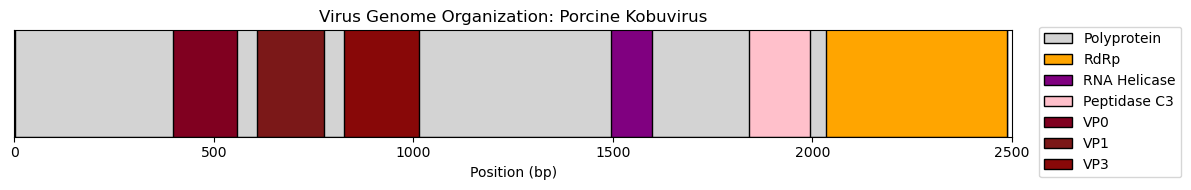

In [92]:
# Set up the figure and axis for the single-line plot with updated annotation
fig, ax = plt.subplots(figsize=(12, 2))

# Define the genomic segments with their start and end positions, and updated annotations
segments = [
    {"name": "Polyprotein", "start": 1, "end": 2488, "color": "lightgray"},
    {"name": "RdRp", "start": 2033, "end": 2488, "color": "orange"},
    {"name": "RNA Helicase", "start": 1496, "end": 1598, "color": "purple"},
    {"name": "Peptidase C3", "start": 1840, "end": 1994, "color": "pink"},
    {"name": "VP0", "start": 397, "end": 557, "color": "#800020"},
    {"name": "VP1", "start": 607, "end": 775, "color": "#7B1818"},
    {"name": "VP3", "start": 826, "end": 1014, "color": "#880808"}
]

# Plot each genomic segment as a colored rectangle
for segment in segments:
    ax.add_patch(patches.Rectangle(
        (segment["start"], 0), 
        segment["end"] - segment["start"], 
        1, 
        facecolor=segment["color"], 
        edgecolor='black',
        label=segment["name"]
    ))

# Set axis labels and title
ax.set_xlim(0, 2500)
ax.set_ylim(0, 0.01)
ax.set_xlabel("Position (bp)")
ax.set_yticks([])  # No Y-axis labels needed
ax.set_title("Virus Genome Organization: Porcine Kobuvirus")

# Add a legend for the segments
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc="upper left", bbox_to_anchor=(1.02, 1.1))

# Display the plot
plt.tight_layout()
plt.show()
